In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append('../src')
from utils.get_prices import *
import matplotlib.pyplot as plt
import seaborn as sns


DATA_PATH = Path('../data')
DATA_PATH_BASKETS = DATA_PATH / 'baskets'
DATA_PATH_RAW = DATA_PATH / 'raw'
DATA_PATH_PROCESSED = DATA_PATH / 'processed'

In [2]:
basket_name = 'all_tickers_20201224'
basket_path = DATA_PATH_BASKETS / (basket_name + '.csv')
tickers = pd.read_csv(basket_path, header=None, names=['Ticker'], squeeze=True)
tickers


0         A
1       AAL
2       AAP
3      AAPL
4      ABBV
       ... 
722    ZION
723      ZM
724      ZS
725     ZTS
726     ZUO
Name: Ticker, Length: 727, dtype: object

In [3]:
%%time

start = '2020-01-01' # start must be at least [window]Ds earlier than bt_start
end = '2020-12-24'

timestamp = start.replace('-', '') + '_' + end.replace('-', '')

price_filename = '_'.join(['prc', basket_name, timestamp]) + '.csv'
price_filepath = DATA_PATH_RAW / price_filename

if Path(price_filepath).exists():
    print("Found existing price file. Reading...")
    prices = pd.read_csv(price_filepath, header=[0, 1], index_col=0,
                         parse_dates=True)
    print("Prices read from: ", price_filepath)
else:
    prices = get_prices(tickers, start, end,
                        types=['Adj Close', 'High'],
                        out_path=price_filepath,
                        sort_tks=True)

Found existing price file. Reading...
Prices read from:  ..\data\raw\prc_all_tickers_20201224_20200101_20201224.csv
Wall time: 165 ms


In [4]:
prices.tail()

Attributes   Adj Close                                                        \
Symbols              A    AAL         AAP        AAPL        ABBV        ABC   
Date                                                                           
2020-12-18  119.300003  16.51  159.990005  126.660004  104.449997  98.610001   
2020-12-21  117.779999  16.10  160.490005  128.229996  103.709999  97.669998   
2020-12-22  117.370003  15.48  159.399994  131.880005  102.800003  96.720001   
2020-12-23  117.300003  15.89  159.289993  130.960007  103.279999  97.239998   
2020-12-24  117.309998  15.66  160.679993  131.970001  103.260002  96.970001   

Attributes                                                 ...        High  \
Symbols           ABMD         ABT         ACN       ACWI  ...           Z   
Date                                                       ...               
2020-12-18  293.390015  108.970001  266.250000  89.779999  ...  140.647995   
2020-12-21  295.809998  108.089996  261.420013  89.209999  ...  136.800003   
2020-12-22  302.329987  108.279999  259.470001  89.059998  ...  144.300003   
2020-12-23  304.049988  107.449997  257.440002  89.480003  ...  142.350006   
2020-12-24  303.410004  108.349998  257.299988  89.589996  ...  143.083496   

Attributes                                                             \
Symbols            ZBH        ZBRA         ZEN          ZG       ZION   
Date                                                                    
2020-12-18  152.419998  378.500000  142.279999  144.130005  41.860001   
2020-12-21  150.240005  376.730011  141.080002  141.550003  42.560001   
2020-12-22  151.699997  387.279999  144.188004  149.440002  42.860001   
2020-12-23  152.300003  384.600006  144.500000  147.990005  43.700001   
2020-12-24  149.699997  382.279999  144.559998  148.130005  43.619999   

Attributes                                              
Symbols             ZM          ZS         ZTS     ZUO  
Date                                                    
2020-12-18  408.109985  198.160004  164.539993  12.900  
2020-12-21  427.759003  200.399994  161.559998  13.240  
2020-12-22  413.500000  208.065002  162.380005  14.080  
2020-12-23  402.600006  212.585007  162.979996  14.135  
2020-12-24  384.880005  209.979996  161.869904  14.600  

[5 rows x 1454 columns]

In [5]:
prices_ad = prices['Adj Close']
prices_hi = prices['High']

In [6]:
backtest_start = '2020-07-01'
backtest_end = end
timestamp_backtest = backtest_start.replace('-', '') + '_' + backtest_end.replace('-', '')

In [7]:
def calc_hit_rate(rtns, thld):
    n_trades = rtns.count(axis=0)
    n_trades.name = 'n_trades'
    n_hits = (rtns >= thld).sum(axis=0, skipna=True)
    n_hits.name = 'n_hits'
    hit_rate = n_hits / n_trades
    hit_rate.name = 'hit_rate'
    return pd.concat([hit_rate, n_trades, n_hits], axis=1)

## Building Block 1
### Calculate Probility of: Return >= [thld_rtn] Over [window_size] Days

In [8]:
def calc_hit_rate_over_roll_window(ad, window, thld, start, end, output=False):
    # calc rolling close to close [window]D return
    roll_rtn_adad = ad.pct_change(window)
    roll_rtn_adad_shifted = roll_rtn_adad.shift(-window).loc[start:].dropna(how='all')

    res = calc_hit_rate(roll_rtn_adad_shifted, thld)

    res = res[['hit_rate', 'n_trades']].rename(columns={
        'hit_rate': ''.join(['% Probability of Price = Close+',
                             format(thld*100, '.0f'),
                             '%, Close+', str(window), 'D From Trade']),
        'n_trades': 'N_Trades'
    })
    # output if path specified
    if output:
        timestamp_backtest = start.replace('-', '') + '_' + end.replace('-', '')
        filename = '_'.join(['prob_rtn_over', format(thld, '.2f'),
                             'over', str(window)+'d', timestamp_backtest])
        filepath = DATA_PATH_PROCESSED / (filename + '.csv')
        res.to_csv(filepath)
        print("Results saved to: ", filepath)
    return res

In [9]:
window_size = 22
thld_rtn = 0.10
res = calc_hit_rate_over_roll_window(
    ad=prices_ad,
    window=window_size,
    thld=thld_rtn,
    start=backtest_start,
    end=backtest_end,
    output=True
)
res

Results saved to:  ..\data\processed\prob_rtn_over_0.10_over_22d_20200701_20201224.csv


,"% Probability of Price = Close+10%, Close+22D From Trade",N_Trades
Symbols,,
A,0.049020,102
AAL,0.352941,102
AAP,0.117647,102
AAPL,0.303922,102
ABBV,0.235294,102
...,...,...
ZION,0.313725,102
ZM,0.431373,102
ZS,0.362745,102


Text(0, 0.5, 'Absolute Frequency')

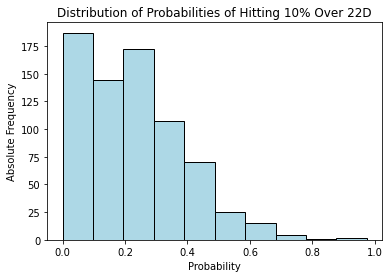

In [10]:
plt.title('Distribution of Probabilities of Hitting 10% Over 22D')
plt.hist(res.iloc[:, 0], bins=10, color='lightblue', edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Absolute Frequency')

## Building Block 2
### Calculate Probility of: Return >= [thld_rtn] Within [window_size] Days(including High Price)

In [11]:
def calc_hit_rate_within_roll_window(ad, hi, window, thld, start, end, output=False):
    # calc highest price in rolling window
    roll_hi = hi.rolling(window).max()
    roll_hi_shifted = roll_hi.shift(-window)
    # calc highest return in rolling window 
    roll_rtn_adhi_shifted = (roll_hi_shifted / ad - 1).loc[start:].dropna(how='all')

    res = calc_hit_rate(roll_rtn_adhi_shifted, thld)

    res = res[['hit_rate', 'n_trades']].rename(columns={
        'hit_rate': ''.join(['% Probability of Price = Close+',
                            format(thld*100, '.0f'),
                            '%, Within Close+', str(window), 'D From Trade']),
        'n_trades': 'N_Trades'
    })
    # output if path specified
    if output:
        timestamp_backtest = start.replace('-', '') + '_' + end.replace('-', '')
        filename = '_'.join(['prob_rtn_over', format(thld, '.2f'),
                             'within', str(window)+'d', timestamp_backtest])
        filepath = DATA_PATH_PROCESSED / (filename + '.csv')
        res.to_csv(filepath)
        print("Results saved to: ", filepath)
    return res

In [12]:
window_size = 22
thld_rtn = 0.10
res2 = calc_hit_rate_within_roll_window(
    ad=prices_ad,
    hi=prices_hi,
    window=window_size,
    thld=thld_rtn,
    start=backtest_start,
    end=backtest_end,
    output=True)
res2

Results saved to:  ..\data\processed\prob_rtn_over_0.10_within_22d_20200701_20201224.csv


,"% Probability of Price = Close+10%, Within Close+22D From Trade",N_Trades
Symbols,,
A,0.333333,102
AAL,0.656863,102
AAP,0.343137,102
AAPL,0.578431,102
ABBV,0.323529,102
...,...,...
ZION,0.656863,102
ZM,0.745098,102
ZS,0.754902,102


In [13]:
window_size = 22
thld_rtn = 0.15
res2 = calc_hit_rate_within_roll_window(
    ad=prices_ad,
    hi=prices_hi,
    window=window_size,
    thld=thld_rtn,
    start=backtest_start,
    end=backtest_end,
    output=True)
res2

Results saved to:  ..\data\processed\prob_rtn_over_0.15_within_22d_20200701_20201224.csv


,"% Probability of Price = Close+15%, Within Close+22D From Trade",N_Trades
Symbols,,
A,0.029412,102
AAL,0.480392,102
AAP,0.107843,102
AAPL,0.392157,102
ABBV,0.186275,102
...,...,...
ZION,0.392157,102
ZM,0.647059,102
ZS,0.529412,102


Text(0, 0.5, 'Absolute Frequency')

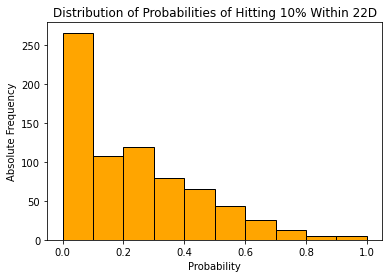

In [14]:

plt.title('Distribution of Probabilities of Hitting 10% Within 22D')
plt.hist(res2.iloc[:, 0], bins=10, color='orange', edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Absolute Frequency')

In [15]:
window_size = 22
thlds = [0.10, 0.15]

probs_within = pd.concat(
    [calc_hit_rate_within_roll_window(
        ad=prices_ad,
        hi=prices_hi,
        window=window_size,
        thld=thld,
        start=backtest_start,
        end=backtest_end)
     for thld in thlds],
    axis=1
)
probs_within

,"% Probability of Price = Close+10%, Within Close+22D From Trade",N_Trades,"% Probability of Price = Close+15%, Within Close+22D From Trade",N_Trades
Symbols,,,,
A,0.333333,102,0.029412,102
AAL,0.656863,102,0.480392,102
AAP,0.343137,102,0.107843,102
AAPL,0.578431,102,0.392157,102
ABBV,0.323529,102,0.186275,102
...,...,...,...,...
ZION,0.656863,102,0.392157,102
ZM,0.745098,102,0.647059,102
ZS,0.754902,102,0.529412,102


In [24]:
filename = '_'.join(['prob_rtn_over', str(thlds),
                     'within', str(window_size)+'d', timestamp_backtest])
filepath = DATA_PATH_PROCESSED / (filename + '.csv')
probs_within.to_csv(filepath)
print("Results saved to: ", filepath)

Results saved to:  ..\data\processed\prob_rtn_over_[0.1, 0.15]_within_22d_20200701_20201224.csv
